<a href="https://colab.research.google.com/github/taavip/automatic-control-of-electrical-equipment-basis-of-price/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

#-----------------------


from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.model_selection import *



In [16]:
def get_tabel():
  url = ('https://dashboard.elering.ee/api/nps/price?start='+str((datetime.now() + timedelta(hours=36)-relativedelta(years=1)).date().strftime("%Y-%m-%d %H:%M"))+'&end='+str((datetime.now() + timedelta(hours=36)).date().strftime("%Y-%m-%d %H:%M")))

  response = requests.get(url).json()

  ep=pd.json_normalize(response['data']['ee'])
  ep['datetime'] = pd.to_datetime(ep['timestamp'], unit='s')
  ep['dow'] = pd.to_datetime(ep['timestamp'], unit='s').dt.dayofweek
  ep['hour'] = pd.to_datetime(ep['timestamp'], unit='s').dt.hour
  ep['week'] = pd.to_datetime(ep['timestamp'], unit='s').dt.isocalendar().week

  url=("http://ohuseire.ee/station/csv?filter%5BstationId%5D=36&filter%5BdateFrom%5D="+str((datetime.now() + timedelta(hours=36)-relativedelta(years=1)).date().strftime("%d.%m.%Y"))+"&filter%5BdateUntil%5D="+str((datetime.now() ).date().strftime("%d.%m.%Y")))

  s=requests.get(url).content
  c=pd.read_csv(io.StringIO(s.decode('utf-8')), sep=';' )

  c['timestamp'] = (pd.to_datetime(c["Kuupäev"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
  d = c[["WD10",'timestamp']]
  c = c.stack().str.replace(',','.').unstack()
  c["NO2"] = pd.to_numeric(c["NO2"], errors='coerce')
  c["CO"] = pd.to_numeric(c["CO"], errors='coerce')
  c["PM10"] = pd.to_numeric(c["PM10"], errors='coerce')
  c["HUM"] = pd.to_numeric(c["HUM"], errors='coerce')
  c["PM2.5"] = pd.to_numeric(c["PM2.5"], errors='coerce')
  c["TEMP"] = pd.to_numeric(c["TEMP"], errors='coerce')
  c["WS10"] = pd.to_numeric(c["WS10"], errors='coerce')
  c["WD10"] = d["WD10"]
  c['timestamp'] = d['timestamp']
  c= c.drop("Kuupäev",axis=1)

  #pd.merge(c, ep, on=['timestamp'])
  return ep


In [17]:
df = get_tabel()


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8783 non-null   int64         
 1   price      8783 non-null   float64       
 2   datetime   8783 non-null   datetime64[ns]
 3   dow        8783 non-null   int64         
 4   hour       8783 non-null   int64         
 5   week       8783 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 386.1 KB


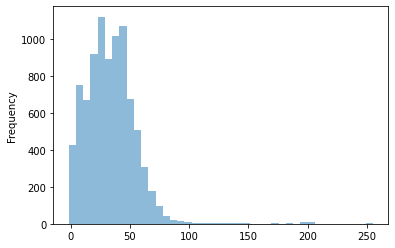

In [19]:
df.price.plot.hist(bins=42, alpha=0.5)

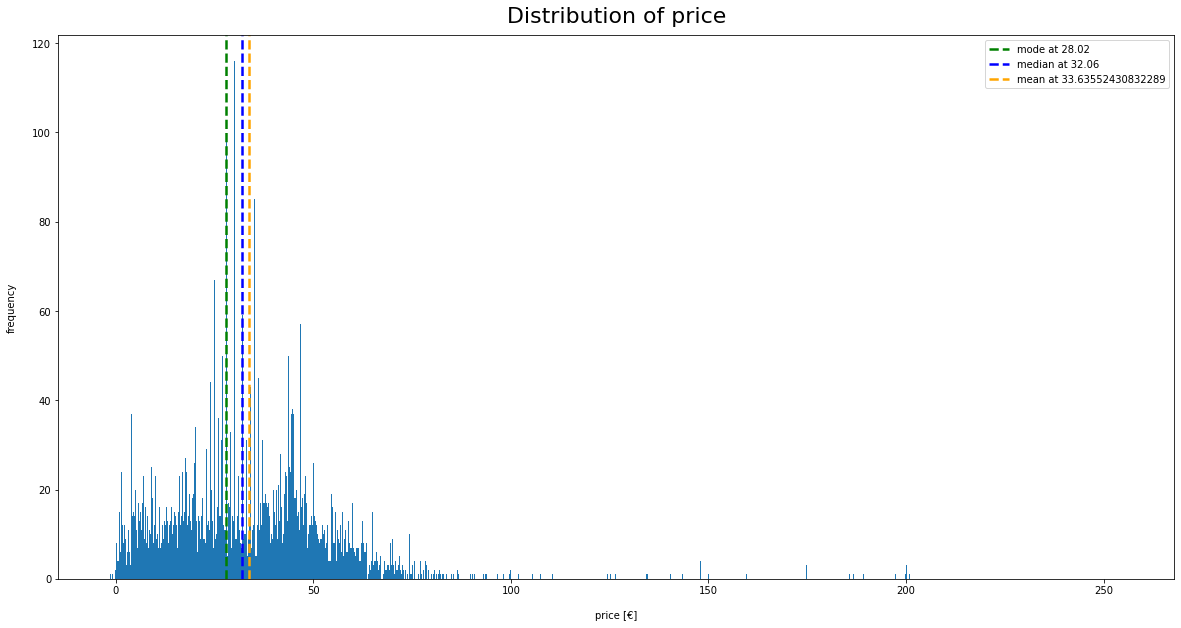

In [8]:
#df['price'].plot(kind='hist', figsize=(10, 8), linewidth=2, color='whitesmoke', edgecolor='gray')
plt.figure(figsize=(20,10))
plt.hist(df['price'], bins=2250 )

plt.xlabel("price [€]", labelpad=15)
plt.ylabel("frequency", labelpad=15)
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of price", y=1.012, fontsize=22)
measurements = [df['price'].mode()[0], df['price'].median(), df['price'].mean()]
names = ["mode", "median", "mean"]
colors = ['green', 'blue', 'orange']
for measurement, name, color in zip(measurements, names, colors):
    plt.axvline(x=measurement, linestyle='--', linewidth=2.5, label='{0} at {1}'.format(name, measurement), c=color)
plt.legend();

In [20]:
def nsmall(a, n):
    return np.partition(a, n)[n]

In [23]:
df["on_off"] = df.price < df.price.rolling(window=23,min_periods=4,center=True).apply(lambda x: nsmall(x, 3))
df.price.rolling(window=24,min_periods=1,)
df.tail(50)

,timestamp,price,datetime,dow,hour,week,on_off
8733,1609189200,19.14,2020-12-28 21:00:00,0,21,53,False
8734,1609192800,15.91,2020-12-28 22:00:00,0,22,53,True
8735,1609196400,17.93,2020-12-28 23:00:00,0,23,53,False
8736,1609200000,17.91,2020-12-29 00:00:00,1,0,53,False
8737,1609203600,17.28,2020-12-29 01:00:00,1,1,53,True
8738,1609207200,17.47,2020-12-29 02:00:00,1,2,53,True
8739,1609210800,18.37,2020-12-29 03:00:00,1,3,53,False
8740,1609214400,20.71,2020-12-29 04:00:00,1,4,53,False
8741,1609218000,42.26,2020-12-29 05:00:00,1,5,53,False
8742,1609221600,48.07,2020-12-29 06:00:00,1,6,53,False


In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true+abs(y_true.min()), y_pred+abs(y_true.min()))
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
data = df.copy()
# creating new dataframe from consumption column
data_consumption = df.copy()
# inserting new column with yesterday's consumption values
#data_consumption.loc[:,'1h'] = data_consumption.loc[:,'price'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
#data_consumption.loc[:,'1h_Diff'] = data_consumption.loc[:,'1h'].diff()

data_consumption['avg24h'] = data_consumption.price.rolling(window=24,min_periods=1).mean()
# dropping NAs
data_consumption = data_consumption.dropna()


In [ ]:

len(data_consumption[:int(len(data_consumption[:])*0.8)])

92

In [ ]:
num = int(len(data_consumption[:])*0.8)
print(num)
X_train = data_consumption[:num].drop(['price', 'datetime'], axis = 1)
y_train = data_consumption.price[:num]
X_test = data_consumption[num:].drop(['price','datetime'], axis = 1)
y_test = data_consumption.price[num:]

92


In [ ]:
y_train

0     40.20
1      9.26
2     40.14
3      8.85
4      5.77
      ...  
89    40.10
90    44.82
91    57.19
92    57.18
93    62.72
Name: price, Length: 92, dtype: float64

LR: -418.318953 (898.288621)
NN: -75.820861 (177.311186)
KNN: -120.539107 (313.985129)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RF: -97.861625 (251.860802)
SVR: -42.796049 (107.034553)


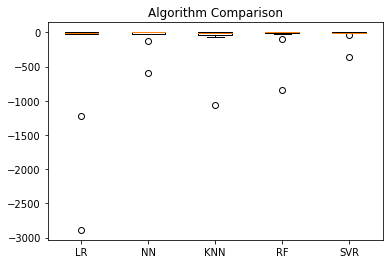

In [ ]:


# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *


model = RandomForestRegressor()
param_search = { 
    'n_estimators': [ 100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(3,11)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.2523
mean_squared_log_error:  0.1343
r2:  0.2402
MAE:  15.0873
MSE:  279.8513
RMSE:  16.7288


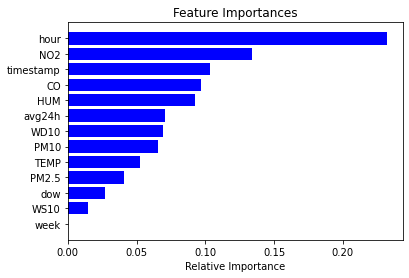

In [ ]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

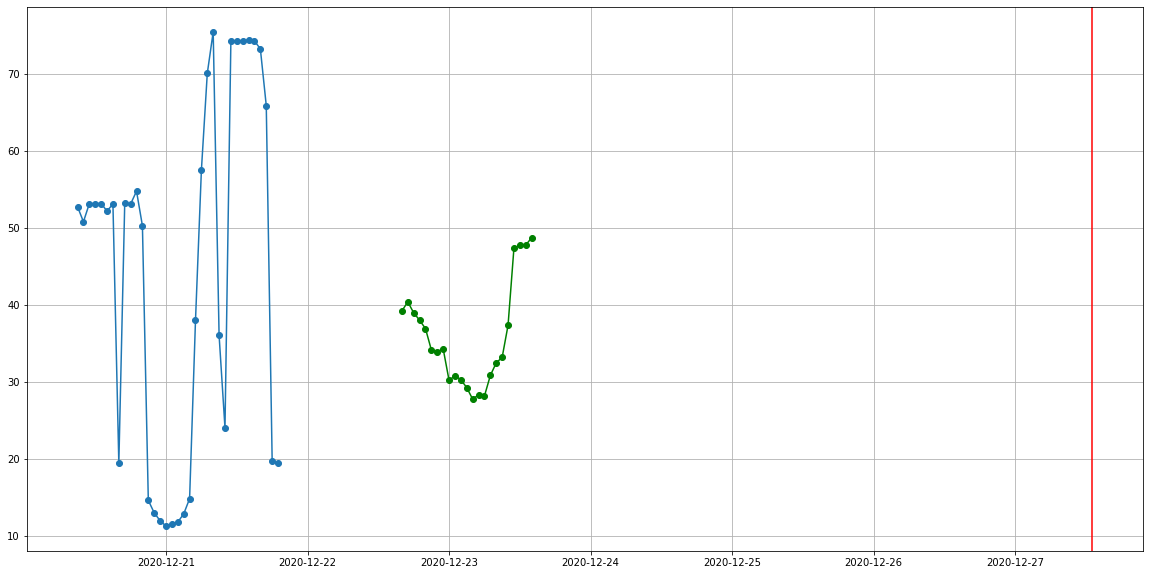

In [ ]:
a =df.loc[:,['price','datetime']][-35:]

plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(a.datetime).dt.tz_localize('Europe/Tallinn'), a.price,  marker='o')
plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s').dt.tz_localize('Europe/Tallinn'), best_model.predict(X_test)[-35:],  marker='o',color='green')
#plt.plot(pd.to_datetime( X_test['timestamp'][-35:], unit='s').dt.tz_localize('Europe/Tallinn'), best_model.predict(X_test)[-35:]-a.price,  marker='x',color='cyan')
plt.grid(b=None, which='major', axis='both')
plt.axvline(x= pd.Timestamp.now(tz = 'Europe/Tallinn'), color='red')